# PROJECT
DATA

In [1]:
from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.nn.utils import spectral_norm
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_path = '/content/gdrive/My Drive/project/pokemon/pokemon data/Data'
results_path = "/content/gdrive/My Drive/project/pokemon/dcgan/pokemon results 819"
checkpoint_path_generator='/content/gdrive/My Drive/project/pokemon/dcgan/pokemon weights 819/generator {} Epoch.pth'
checkpoint_path_discriminator='/content/gdrive/My Drive/project/pokemon/dcgan/pokemon weights 819/discriminator {} Epoch.pth'

In [4]:
image_size = 64
batch_size = 32
normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) # Convert channels from [0, 1] to [-1, 1] -> (img - 0.5)/0.5 for each channel

we will preform data augmentation to increase the amout of data

In [5]:
normal = ImageFolder(data_path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with mirrored images
mirror = ImageFolder(data_path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Augment the dataset with color changes
color = ImageFolder(data_path, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)]))

# Combine the datasets
dataset_list = [normal, mirror, color]
dataset = ConcatDataset(dataset_list)
dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=0, pin_memory=False)

Since these images have been normalized to [-1, 1],  we need to denormalize them in order to view them. Below is a denormalization function to do just that.

In [6]:
def denorm(image):
    return image * 0.5 +0.5

Now let's show a sample batch of real Pokemon images

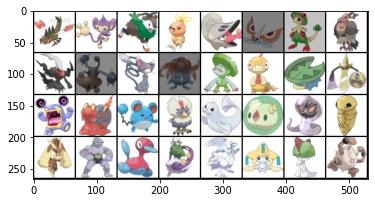

In [7]:
images, labels = next(iter(dataloader))
plt.imshow(make_grid(denorm(images), nrow=8).permute(1, 2, 0))

GPU setup

In [8]:
def get_training_device():
    # Use the GPU if possible
    if torch.cuda.is_available():
        return torch.device('cuda')
    # Otherwise use the CPU :-(
    return torch.device('cpu')

def to_device(data, device):
    # This moves the tensors to the device (GPU, CPU)
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

device = get_training_device()
device

device(type='cpu')

Now that we know the visualization works, we can continue with making the GAN. First, we'll start with the discriminator

Discriminator Model

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map,we could use maxpolling instead of stride .



In [9]:
Discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False)),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

Note that we're using the Leaky ReLU activation for the discriminator.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">


>  Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

LeakyReLU(x)=max(0,x)+negative_slope∗min(0,x)

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being real i.e. picked from the original dataset.



In [10]:
from torchsummary import summary
discriminator =  Discriminator
discriminator  = to_device(discriminator , device)
summary(discriminator, (3,image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13              [-1, 1, 1, 1]           8,192
          Flatten-14                   

 Generator Model


The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(latent_size , 1, 1)` into an image tensor of shape `3 x image_size x image_size`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

In [11]:
latent_size = 128
Generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [21]:
generator =  Generator
generator  = to_device(generator , device)
summary(generator, (latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,


This is to make sure everything is the correct size

torch.Size([8, 3, 64, 64])


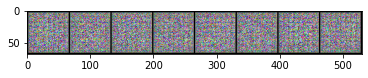

In [12]:
generator=Generator
fakePokemon = generator(torch.randn(8, latent_size, 1, 1,device=device)) # generator on 8 random noise vectors of shape latent_size,1,1
print(fakePokemon.shape) # return 8 images 
plt.imshow(make_grid(denorm(fakePokemon.cpu()), nrow=8).permute(1, 2, 0))

In [13]:
dev_dataloader = DeviceDataLoader(dataloader, device) # move the data to device

**Training Functions**

 Discriminator

In [14]:
def AddNoise(labels, prob): # create incorrect samples  
    num = int(prob * labels.shape[0])
    flipped = np.random.choice([i for i in range(labels.shape[0])], size=num)
    for i in flipped:
        labels[i] = 1 - labels[i]
    return labels


def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.randn(real_images.size(0), 1, device=device) * .15 + .85 #real target = 0.85 + gaussain noise N ~ (0,0.15^2) 
    real_targets = AddNoise(real_targets, .05) 
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.randn(fake_images.size(0), 1, device=device) * .15 + .15
    fake_targets = AddNoise(fake_targets, .05)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real  dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 0.85 + gaussian noise (smoothing label). 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.15 + gaussian noise. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

 Generator

In [15]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()



Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator. 

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.


Save Results

In [16]:
import os
from torchvision.utils import save_image
os.makedirs(results_path, exist_ok=True)

def SaveResults(index):

    # Generate fake pokemon
    vectors = torch.randn(64, latent_size, 1, 1, device=device) # 64 vectors of length latent_Size 
    FakePokemon = generator(vectors) # create 64  fake images
    
    # Make the filename for the output
    file = "{} Epoch .jpg".format(index)
    
    # Save the image
    save_image(denorm(FakePokemon), os.path.join(results_path, file), nrow=8) #saving 64 fake images as 8x8 grid - save_image is calling make_grid automaticlly
    print("Result Saved!")
    

 **Full Training**

## Full Training 

Let's define a `train` function to train the discriminator and generator  for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [17]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

SaveResults(0) #  EPOCH 0 before we trained the generator

def train(epochs, learning_rate, startIdx=1,
          checkpoint_path_generator = checkpoint_path_generator,
          checkpoint_path_discriminator=checkpoint_path_discriminator):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()
    
    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    fake_scores = []
    
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img, _ in tqdm(dev_dataloader):
            # Train the discriminator
            disc_loss, real_score, fake_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss = train_generator(gen_optimizer)
        
        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        fake_scores.append(fake_score)
        gen_losses.append(gen_loss)
        
        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch+startIdx, epochs+startIdx-1, gen_loss, disc_loss, real_score, fake_score))
        if  (epoch + startIdx) % 5 == 0 :
            torch.save(generator.state_dict(), checkpoint_path_generator.format(epoch + startIdx))
            torch.save(discriminator.state_dict(), checkpoint_path_discriminator.format(epoch + startIdx))
        
        # Save the images and show the progress
        SaveResults(epoch + startIdx)
    
    # Return stats
    return disc_losses, disc_scores,fake_scores, gen_losses

Result Saved!


In [18]:
learning_rate = 0.0002
epochs = 290

In [19]:
# loading model weights :
def load_weights(n) :
  generator.load_state_dict(torch.load(checkpoint_path_generator.format(n))) 
  discriminator.load_state_dict(torch.load(checkpoint_path_discriminator.format(n)))

In [ ]:
load_weights(210)
SaveResults(210)

Result Saved!


In [ ]:
history = train(epochs, learning_rate,startIdx = 211)

  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [211/500], gen_loss: 2.2896, disc_loss: 1.0974, real_score: 0.8550, gen_score: 0.1928
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [212/500], gen_loss: 2.1343, disc_loss: 0.9704, real_score: 0.7839, gen_score: 0.2417
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [213/500], gen_loss: 2.1281, disc_loss: 0.9035, real_score: 0.8420, gen_score: 0.1991
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [214/500], gen_loss: 2.0186, disc_loss: 1.0018, real_score: 0.6921, gen_score: 0.1116
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [215/500], gen_loss: 1.4297, disc_loss: 0.8834, real_score: 0.8768, gen_score: 0.2056
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [216/500], gen_loss: 1.6248, disc_loss: 0.9781, real_score: 0.8616, gen_score: 0.2265
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [217/500], gen_loss: 1.7101, disc_loss: 0.9896, real_score: 0.8353, gen_score: 0.1962
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [218/500], gen_loss: 1.2801, disc_loss: 0.9819, real_score: 0.7435, gen_score: 0.1820
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [219/500], gen_loss: 1.6820, disc_loss: 1.0061, real_score: 0.8461, gen_score: 0.1961
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [220/500], gen_loss: 1.6658, disc_loss: 1.0148, real_score: 0.8675, gen_score: 0.3046
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [221/500], gen_loss: 1.5555, disc_loss: 1.0857, real_score: 0.7278, gen_score: 0.1678
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [222/500], gen_loss: 1.8370, disc_loss: 0.9642, real_score: 0.8890, gen_score: 0.2868
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [223/500], gen_loss: 1.4006, disc_loss: 1.0649, real_score: 0.6109, gen_score: 0.1319
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [224/500], gen_loss: 1.3850, disc_loss: 1.0936, real_score: 0.7689, gen_score: 0.1550
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [225/500], gen_loss: 2.4279, disc_loss: 0.9021, real_score: 0.8169, gen_score: 0.1299
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [226/500], gen_loss: 1.5264, disc_loss: 0.9793, real_score: 0.8326, gen_score: 0.1907
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [227/500], gen_loss: 1.4288, disc_loss: 0.9702, real_score: 0.7605, gen_score: 0.1949
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [228/500], gen_loss: 1.9677, disc_loss: 1.0356, real_score: 0.8292, gen_score: 0.2369
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [229/500], gen_loss: 1.7676, disc_loss: 0.9067, real_score: 0.8880, gen_score: 0.2475
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [230/500], gen_loss: 1.5492, disc_loss: 0.9190, real_score: 0.7936, gen_score: 0.2727
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [231/500], gen_loss: 2.0775, disc_loss: 1.0636, real_score: 0.8649, gen_score: 0.2092
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [232/500], gen_loss: 1.2601, disc_loss: 0.9555, real_score: 0.7556, gen_score: 0.1978
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [233/500], gen_loss: 1.7151, disc_loss: 0.9658, real_score: 0.9032, gen_score: 0.2654
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [234/500], gen_loss: 1.4113, disc_loss: 0.9820, real_score: 0.7530, gen_score: 0.1881
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [235/500], gen_loss: 1.9666, disc_loss: 1.0640, real_score: 0.8523, gen_score: 0.2873
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [236/500], gen_loss: 1.6784, disc_loss: 0.8787, real_score: 0.6876, gen_score: 0.1360
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [237/500], gen_loss: 1.5990, disc_loss: 0.9984, real_score: 0.7340, gen_score: 0.1666
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [238/500], gen_loss: 2.0052, disc_loss: 0.9097, real_score: 0.8098, gen_score: 0.1917
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [239/500], gen_loss: 1.7907, disc_loss: 0.8601, real_score: 0.8177, gen_score: 0.2652
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [240/500], gen_loss: 1.7011, disc_loss: 0.9390, real_score: 0.7218, gen_score: 0.2110
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [241/500], gen_loss: 2.2602, disc_loss: 1.0554, real_score: 0.8464, gen_score: 0.2525
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [242/500], gen_loss: 1.8376, disc_loss: 0.8537, real_score: 0.7216, gen_score: 0.1447
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [243/500], gen_loss: 1.6790, disc_loss: 0.9901, real_score: 0.7177, gen_score: 0.1614
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [244/500], gen_loss: 1.6887, disc_loss: 0.8543, real_score: 0.8108, gen_score: 0.2402
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [245/500], gen_loss: 2.1230, disc_loss: 0.9711, real_score: 0.8476, gen_score: 0.1979
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [246/500], gen_loss: 2.2620, disc_loss: 0.9238, real_score: 0.7831, gen_score: 0.1943
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [247/500], gen_loss: 0.9857, disc_loss: 1.0504, real_score: 0.6462, gen_score: 0.1638
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [248/500], gen_loss: 1.7350, disc_loss: 0.8192, real_score: 0.8542, gen_score: 0.2764
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [249/500], gen_loss: 2.1766, disc_loss: 0.9275, real_score: 0.7746, gen_score: 0.2024
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [250/500], gen_loss: 1.7507, disc_loss: 0.9312, real_score: 0.7234, gen_score: 0.1476
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [251/500], gen_loss: 1.7573, disc_loss: 0.9600, real_score: 0.8178, gen_score: 0.2161
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [252/500], gen_loss: 1.8345, disc_loss: 0.9913, real_score: 0.8515, gen_score: 0.2059
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [253/500], gen_loss: 1.6561, disc_loss: 0.9241, real_score: 0.8448, gen_score: 0.2033
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [254/500], gen_loss: 2.0609, disc_loss: 0.9635, real_score: 0.8366, gen_score: 0.3154
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [255/500], gen_loss: 1.9944, disc_loss: 1.0649, real_score: 0.8891, gen_score: 0.2704
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [256/500], gen_loss: 1.9575, disc_loss: 0.9965, real_score: 0.8389, gen_score: 0.3312
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [257/500], gen_loss: 1.6579, disc_loss: 1.0227, real_score: 0.7848, gen_score: 0.1853
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [258/500], gen_loss: 2.0949, disc_loss: 0.8669, real_score: 0.8406, gen_score: 0.2476
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [259/500], gen_loss: 1.9483, disc_loss: 0.9037, real_score: 0.8395, gen_score: 0.1502
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [260/500], gen_loss: 1.8874, disc_loss: 0.9806, real_score: 0.8303, gen_score: 0.2197
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [261/500], gen_loss: 1.6253, disc_loss: 0.8555, real_score: 0.8743, gen_score: 0.2693
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [262/500], gen_loss: 1.8847, disc_loss: 0.8343, real_score: 0.8407, gen_score: 0.2185
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [263/500], gen_loss: 1.8461, disc_loss: 1.0454, real_score: 0.7870, gen_score: 0.1486
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [264/500], gen_loss: 1.9845, disc_loss: 1.1103, real_score: 0.9227, gen_score: 0.3311
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [265/500], gen_loss: 1.9154, disc_loss: 1.0918, real_score: 0.7420, gen_score: 0.2380
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [266/500], gen_loss: 2.1540, disc_loss: 0.8884, real_score: 0.8314, gen_score: 0.2259
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [267/500], gen_loss: 2.0766, disc_loss: 0.9273, real_score: 0.8383, gen_score: 0.2312
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [268/500], gen_loss: 1.8785, disc_loss: 0.8963, real_score: 0.6971, gen_score: 0.1383
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [269/500], gen_loss: 1.2166, disc_loss: 0.9846, real_score: 0.6975, gen_score: 0.1790
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [270/500], gen_loss: 1.2958, disc_loss: 0.9652, real_score: 0.7224, gen_score: 0.1532
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [271/500], gen_loss: 1.8831, disc_loss: 1.0609, real_score: 0.7463, gen_score: 0.2104
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [272/500], gen_loss: 1.9148, disc_loss: 1.0027, real_score: 0.8724, gen_score: 0.3274
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [273/500], gen_loss: 1.7217, disc_loss: 1.0501, real_score: 0.6984, gen_score: 0.1422
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [274/500], gen_loss: 1.9354, disc_loss: 0.9422, real_score: 0.8160, gen_score: 0.1813
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [275/500], gen_loss: 1.5432, disc_loss: 0.9482, real_score: 0.7009, gen_score: 0.1682
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [276/500], gen_loss: 1.7506, disc_loss: 0.8775, real_score: 0.8198, gen_score: 0.2229
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [277/500], gen_loss: 2.1299, disc_loss: 1.0172, real_score: 0.7789, gen_score: 0.1184
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [278/500], gen_loss: 1.8528, disc_loss: 0.9453, real_score: 0.7518, gen_score: 0.2073
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [279/500], gen_loss: 1.6522, disc_loss: 0.9059, real_score: 0.7731, gen_score: 0.1577
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [280/500], gen_loss: 1.6572, disc_loss: 0.8986, real_score: 0.7863, gen_score: 0.2065
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [281/500], gen_loss: 1.2006, disc_loss: 0.9969, real_score: 0.7444, gen_score: 0.1981
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [282/500], gen_loss: 1.3947, disc_loss: 1.0223, real_score: 0.8118, gen_score: 0.1745
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [283/500], gen_loss: 1.8099, disc_loss: 0.9641, real_score: 0.8687, gen_score: 0.2612
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [284/500], gen_loss: 1.8793, disc_loss: 1.0308, real_score: 0.8127, gen_score: 0.2297
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [285/500], gen_loss: 2.2655, disc_loss: 0.9749, real_score: 0.8234, gen_score: 0.1949
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [286/500], gen_loss: 1.3286, disc_loss: 1.0603, real_score: 0.7061, gen_score: 0.2261
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [287/500], gen_loss: 1.7385, disc_loss: 1.0172, real_score: 0.6155, gen_score: 0.0856
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [288/500], gen_loss: 1.8468, disc_loss: 0.9128, real_score: 0.8239, gen_score: 0.1937
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [289/500], gen_loss: 1.8492, disc_loss: 0.9826, real_score: 0.7689, gen_score: 0.1554
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [290/500], gen_loss: 1.8779, disc_loss: 0.9729, real_score: 0.8116, gen_score: 0.1994
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [291/500], gen_loss: 1.2995, disc_loss: 1.0439, real_score: 0.6000, gen_score: 0.1369
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [292/500], gen_loss: 1.7638, disc_loss: 0.9122, real_score: 0.8266, gen_score: 0.1983
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [293/500], gen_loss: 1.6219, disc_loss: 0.8867, real_score: 0.7886, gen_score: 0.1661
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [294/500], gen_loss: 2.1801, disc_loss: 0.9622, real_score: 0.8625, gen_score: 0.1888
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [295/500], gen_loss: 2.0535, disc_loss: 1.0245, real_score: 0.8600, gen_score: 0.2034
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [296/500], gen_loss: 2.2656, disc_loss: 1.0016, real_score: 0.7563, gen_score: 0.1882
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [297/500], gen_loss: 1.4712, disc_loss: 1.0600, real_score: 0.6676, gen_score: 0.1358
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [298/500], gen_loss: 1.7481, disc_loss: 1.0413, real_score: 0.8307, gen_score: 0.3035
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [299/500], gen_loss: 1.5585, disc_loss: 1.0506, real_score: 0.8749, gen_score: 0.2830
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [300/500], gen_loss: 1.4118, disc_loss: 1.0141, real_score: 0.7648, gen_score: 0.1907
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [301/500], gen_loss: 1.6180, disc_loss: 1.0094, real_score: 0.7257, gen_score: 0.1548
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [302/500], gen_loss: 1.8441, disc_loss: 1.0090, real_score: 0.7750, gen_score: 0.2268
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [303/500], gen_loss: 1.4770, disc_loss: 0.9451, real_score: 0.7442, gen_score: 0.1889
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [304/500], gen_loss: 1.6341, disc_loss: 0.8867, real_score: 0.8829, gen_score: 0.2427
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [305/500], gen_loss: 2.1972, disc_loss: 1.0274, real_score: 0.7941, gen_score: 0.1480
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [306/500], gen_loss: 1.7538, disc_loss: 0.9630, real_score: 0.8198, gen_score: 0.1524
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [307/500], gen_loss: 2.0486, disc_loss: 0.8962, real_score: 0.8029, gen_score: 0.1524
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [308/500], gen_loss: 1.5808, disc_loss: 0.9828, real_score: 0.6918, gen_score: 0.1541
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [309/500], gen_loss: 1.4895, disc_loss: 1.1300, real_score: 0.7426, gen_score: 0.1760
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [310/500], gen_loss: 1.9104, disc_loss: 1.0752, real_score: 0.8371, gen_score: 0.2072
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [311/500], gen_loss: 1.4917, disc_loss: 0.9188, real_score: 0.6893, gen_score: 0.1521
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [312/500], gen_loss: 2.0010, disc_loss: 1.0357, real_score: 0.8716, gen_score: 0.2761
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [313/500], gen_loss: 1.9738, disc_loss: 1.0626, real_score: 0.8522, gen_score: 0.2471
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [314/500], gen_loss: 1.7448, disc_loss: 1.0120, real_score: 0.8019, gen_score: 0.2384
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [315/500], gen_loss: 1.6155, disc_loss: 0.9443, real_score: 0.8275, gen_score: 0.2304
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [316/500], gen_loss: 1.9258, disc_loss: 0.9463, real_score: 0.8206, gen_score: 0.2634
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [317/500], gen_loss: 1.2599, disc_loss: 0.9372, real_score: 0.8021, gen_score: 0.1811
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [318/500], gen_loss: 2.2889, disc_loss: 1.0219, real_score: 0.8241, gen_score: 0.1510
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [319/500], gen_loss: 1.6481, disc_loss: 0.9005, real_score: 0.8521, gen_score: 0.2533
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [320/500], gen_loss: 2.0647, disc_loss: 0.9181, real_score: 0.7862, gen_score: 0.1841
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [321/500], gen_loss: 1.7544, disc_loss: 1.0937, real_score: 0.8541, gen_score: 0.2530
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [322/500], gen_loss: 2.0694, disc_loss: 0.8873, real_score: 0.7482, gen_score: 0.1436
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [323/500], gen_loss: 1.7289, disc_loss: 0.9329, real_score: 0.7932, gen_score: 0.2414
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [324/500], gen_loss: 1.6343, disc_loss: 1.0353, real_score: 0.8472, gen_score: 0.1713
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [325/500], gen_loss: 2.0216, disc_loss: 1.0275, real_score: 0.8822, gen_score: 0.2772
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [326/500], gen_loss: 1.2866, disc_loss: 0.9363, real_score: 0.8066, gen_score: 0.2227
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [327/500], gen_loss: 1.9571, disc_loss: 1.0600, real_score: 0.8542, gen_score: 0.2436
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [328/500], gen_loss: 1.7935, disc_loss: 0.9235, real_score: 0.8834, gen_score: 0.2078
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [329/500], gen_loss: 1.6539, disc_loss: 1.0059, real_score: 0.8565, gen_score: 0.2485
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [330/500], gen_loss: 1.6667, disc_loss: 0.9759, real_score: 0.7395, gen_score: 0.1705
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [331/500], gen_loss: 1.4101, disc_loss: 0.8988, real_score: 0.7768, gen_score: 0.2391
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [332/500], gen_loss: 1.6751, disc_loss: 0.9757, real_score: 0.7450, gen_score: 0.1657
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [333/500], gen_loss: 2.2569, disc_loss: 1.0088, real_score: 0.8313, gen_score: 0.2620
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [334/500], gen_loss: 1.6567, disc_loss: 0.9761, real_score: 0.7257, gen_score: 0.1732
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [335/500], gen_loss: 1.7360, disc_loss: 0.8721, real_score: 0.8264, gen_score: 0.1916
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [336/500], gen_loss: 1.5460, disc_loss: 1.1642, real_score: 0.5437, gen_score: 0.1230
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [337/500], gen_loss: 1.8324, disc_loss: 0.8539, real_score: 0.7814, gen_score: 0.1975
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [338/500], gen_loss: 1.8067, disc_loss: 0.9486, real_score: 0.8102, gen_score: 0.1828
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [339/500], gen_loss: 1.4113, disc_loss: 0.9935, real_score: 0.6792, gen_score: 0.1583
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [340/500], gen_loss: 1.5516, disc_loss: 0.9830, real_score: 0.7815, gen_score: 0.1589
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [341/500], gen_loss: 1.4140, disc_loss: 0.9995, real_score: 0.7565, gen_score: 0.1611
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [342/500], gen_loss: 1.7059, disc_loss: 1.0387, real_score: 0.7163, gen_score: 0.1755
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [343/500], gen_loss: 1.7243, disc_loss: 1.0070, real_score: 0.8497, gen_score: 0.1957
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [344/500], gen_loss: 1.7297, disc_loss: 0.9629, real_score: 0.7887, gen_score: 0.1571
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [345/500], gen_loss: 1.7182, disc_loss: 0.8664, real_score: 0.7909, gen_score: 0.1533
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [346/500], gen_loss: 1.7908, disc_loss: 1.0332, real_score: 0.8163, gen_score: 0.2007
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [347/500], gen_loss: 1.5730, disc_loss: 0.8470, real_score: 0.8300, gen_score: 0.2343
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [348/500], gen_loss: 1.7349, disc_loss: 1.0419, real_score: 0.7958, gen_score: 0.2725
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [349/500], gen_loss: 1.4647, disc_loss: 0.9532, real_score: 0.8170, gen_score: 0.2232
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [350/500], gen_loss: 1.5967, disc_loss: 0.8784, real_score: 0.7967, gen_score: 0.2217
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [351/500], gen_loss: 1.5155, disc_loss: 0.9572, real_score: 0.7013, gen_score: 0.1935
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [352/500], gen_loss: 1.8828, disc_loss: 1.0117, real_score: 0.7967, gen_score: 0.1739
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [353/500], gen_loss: 1.6130, disc_loss: 0.9820, real_score: 0.7625, gen_score: 0.1846
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [354/500], gen_loss: 1.5662, disc_loss: 0.8815, real_score: 0.8710, gen_score: 0.2185
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [355/500], gen_loss: 1.8735, disc_loss: 1.0421, real_score: 0.7760, gen_score: 0.1514
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [356/500], gen_loss: 1.8100, disc_loss: 1.0023, real_score: 0.8199, gen_score: 0.2361
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [357/500], gen_loss: 1.8677, disc_loss: 1.0358, real_score: 0.8206, gen_score: 0.1999
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [358/500], gen_loss: 1.8593, disc_loss: 0.8006, real_score: 0.7582, gen_score: 0.1810
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [359/500], gen_loss: 2.0102, disc_loss: 0.9344, real_score: 0.8039, gen_score: 0.1980
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [360/500], gen_loss: 1.7082, disc_loss: 0.9649, real_score: 0.7859, gen_score: 0.1699
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [361/500], gen_loss: 2.1941, disc_loss: 1.0421, real_score: 0.8994, gen_score: 0.2043
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [362/500], gen_loss: 1.7722, disc_loss: 0.9356, real_score: 0.8201, gen_score: 0.1976
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [363/500], gen_loss: 1.8563, disc_loss: 1.0397, real_score: 0.8511, gen_score: 0.1699
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [364/500], gen_loss: 2.1544, disc_loss: 1.0213, real_score: 0.8092, gen_score: 0.1814
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [365/500], gen_loss: 1.8370, disc_loss: 1.0601, real_score: 0.8182, gen_score: 0.1507
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [366/500], gen_loss: 1.3758, disc_loss: 1.0350, real_score: 0.8123, gen_score: 0.2109
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [367/500], gen_loss: 1.9238, disc_loss: 0.9500, real_score: 0.8232, gen_score: 0.2749
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [368/500], gen_loss: 1.5508, disc_loss: 0.9872, real_score: 0.8482, gen_score: 0.2694
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [369/500], gen_loss: 2.0771, disc_loss: 0.9924, real_score: 0.8510, gen_score: 0.2419
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [370/500], gen_loss: 2.0389, disc_loss: 0.9294, real_score: 0.7710, gen_score: 0.1427
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [371/500], gen_loss: 1.6237, disc_loss: 0.9804, real_score: 0.8183, gen_score: 0.2156
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [372/500], gen_loss: 1.6148, disc_loss: 0.8842, real_score: 0.8366, gen_score: 0.3050
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [373/500], gen_loss: 1.9250, disc_loss: 0.9660, real_score: 0.7684, gen_score: 0.1835
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [374/500], gen_loss: 1.6827, disc_loss: 0.9165, real_score: 0.7914, gen_score: 0.2213
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [375/500], gen_loss: 1.6053, disc_loss: 1.1439, real_score: 0.8820, gen_score: 0.3304
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [376/500], gen_loss: 1.9399, disc_loss: 0.9962, real_score: 0.8640, gen_score: 0.1493
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [377/500], gen_loss: 2.0726, disc_loss: 0.9751, real_score: 0.7643, gen_score: 0.1353
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [378/500], gen_loss: 2.2903, disc_loss: 0.9608, real_score: 0.8173, gen_score: 0.1650
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [379/500], gen_loss: 1.9699, disc_loss: 0.8844, real_score: 0.8238, gen_score: 0.1871
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [380/500], gen_loss: 1.8733, disc_loss: 0.8213, real_score: 0.7926, gen_score: 0.1398
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [381/500], gen_loss: 2.1191, disc_loss: 0.8819, real_score: 0.8433, gen_score: 0.2068
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [382/500], gen_loss: 1.8333, disc_loss: 1.0325, real_score: 0.8355, gen_score: 0.2318
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [383/500], gen_loss: 2.1108, disc_loss: 1.0003, real_score: 0.8092, gen_score: 0.1883
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [384/500], gen_loss: 1.9085, disc_loss: 0.9921, real_score: 0.8406, gen_score: 0.2298
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [385/500], gen_loss: 2.3024, disc_loss: 0.9137, real_score: 0.8085, gen_score: 0.1927
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [386/500], gen_loss: 1.4856, disc_loss: 0.9450, real_score: 0.8064, gen_score: 0.1825
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [387/500], gen_loss: 1.8086, disc_loss: 1.0819, real_score: 0.8125, gen_score: 0.2452
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [388/500], gen_loss: 2.0602, disc_loss: 0.8875, real_score: 0.8621, gen_score: 0.2191
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [389/500], gen_loss: 1.3447, disc_loss: 0.8995, real_score: 0.8506, gen_score: 0.2907
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [390/500], gen_loss: 1.5880, disc_loss: 1.0154, real_score: 0.8386, gen_score: 0.2641
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [391/500], gen_loss: 1.8031, disc_loss: 1.0019, real_score: 0.8144, gen_score: 0.1486
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [392/500], gen_loss: 1.9717, disc_loss: 0.8472, real_score: 0.8141, gen_score: 0.2155
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [393/500], gen_loss: 1.8803, disc_loss: 0.9508, real_score: 0.7802, gen_score: 0.1957
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [394/500], gen_loss: 1.9142, disc_loss: 0.8841, real_score: 0.8343, gen_score: 0.1932
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [395/500], gen_loss: 2.3112, disc_loss: 0.9836, real_score: 0.8818, gen_score: 0.2240
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [396/500], gen_loss: 1.7182, disc_loss: 0.8684, real_score: 0.8203, gen_score: 0.1848
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [397/500], gen_loss: 1.5445, disc_loss: 0.9920, real_score: 0.6654, gen_score: 0.1078
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [398/500], gen_loss: 2.3410, disc_loss: 0.9041, real_score: 0.7804, gen_score: 0.1645
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [399/500], gen_loss: 1.1884, disc_loss: 0.9867, real_score: 0.7387, gen_score: 0.1959
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [400/500], gen_loss: 2.1131, disc_loss: 1.0085, real_score: 0.7872, gen_score: 0.1970
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [401/500], gen_loss: 2.0081, disc_loss: 1.0200, real_score: 0.8646, gen_score: 0.2969
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [402/500], gen_loss: 2.2067, disc_loss: 1.0824, real_score: 0.8360, gen_score: 0.1540
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [403/500], gen_loss: 2.1061, disc_loss: 1.0145, real_score: 0.8198, gen_score: 0.2309
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [404/500], gen_loss: 1.6591, disc_loss: 0.8474, real_score: 0.8396, gen_score: 0.3170
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [405/500], gen_loss: 2.1659, disc_loss: 0.9310, real_score: 0.8094, gen_score: 0.2214
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [406/500], gen_loss: 1.3272, disc_loss: 0.9487, real_score: 0.7789, gen_score: 0.1896
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [407/500], gen_loss: 1.8858, disc_loss: 0.9626, real_score: 0.7950, gen_score: 0.3311
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [408/500], gen_loss: 1.9458, disc_loss: 0.9704, real_score: 0.8104, gen_score: 0.1303
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [409/500], gen_loss: 1.5259, disc_loss: 1.0656, real_score: 0.8705, gen_score: 0.3345
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [410/500], gen_loss: 1.8979, disc_loss: 0.9494, real_score: 0.7415, gen_score: 0.1624
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [411/500], gen_loss: 1.2118, disc_loss: 1.0060, real_score: 0.8209, gen_score: 0.1877
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [412/500], gen_loss: 1.9496, disc_loss: 1.0077, real_score: 0.7585, gen_score: 0.1311
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [413/500], gen_loss: 1.6627, disc_loss: 1.0930, real_score: 0.6595, gen_score: 0.0988
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [414/500], gen_loss: 1.7456, disc_loss: 0.8402, real_score: 0.8464, gen_score: 0.1523
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [415/500], gen_loss: 1.9581, disc_loss: 0.9354, real_score: 0.8655, gen_score: 0.2596
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [416/500], gen_loss: 2.1954, disc_loss: 0.8936, real_score: 0.8583, gen_score: 0.1199
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [417/500], gen_loss: 2.0023, disc_loss: 0.9323, real_score: 0.7038, gen_score: 0.1050
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [418/500], gen_loss: 1.8953, disc_loss: 0.8950, real_score: 0.8423, gen_score: 0.2583
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [419/500], gen_loss: 1.7618, disc_loss: 0.8974, real_score: 0.8244, gen_score: 0.1713
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [420/500], gen_loss: 1.7902, disc_loss: 0.9562, real_score: 0.8482, gen_score: 0.2477
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [421/500], gen_loss: 1.6967, disc_loss: 0.9217, real_score: 0.7453, gen_score: 0.1959
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [422/500], gen_loss: 1.7163, disc_loss: 1.1608, real_score: 0.7908, gen_score: 0.1578
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [423/500], gen_loss: 1.7525, disc_loss: 0.8896, real_score: 0.7771, gen_score: 0.1131
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [424/500], gen_loss: 1.6652, disc_loss: 0.9293, real_score: 0.8606, gen_score: 0.1793
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [425/500], gen_loss: 2.0110, disc_loss: 0.9935, real_score: 0.8138, gen_score: 0.2035
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [426/500], gen_loss: 2.1036, disc_loss: 0.8919, real_score: 0.8805, gen_score: 0.2854
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [427/500], gen_loss: 1.7698, disc_loss: 0.9438, real_score: 0.7031, gen_score: 0.1595
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [428/500], gen_loss: 1.7678, disc_loss: 0.9784, real_score: 0.8471, gen_score: 0.1947
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [429/500], gen_loss: 1.7210, disc_loss: 0.9355, real_score: 0.8382, gen_score: 0.1999
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [430/500], gen_loss: 1.6787, disc_loss: 0.9083, real_score: 0.7579, gen_score: 0.1319
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [431/500], gen_loss: 2.2562, disc_loss: 0.9460, real_score: 0.8392, gen_score: 0.1852
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [432/500], gen_loss: 2.3741, disc_loss: 0.9645, real_score: 0.7984, gen_score: 0.2243
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [433/500], gen_loss: 2.6367, disc_loss: 0.9440, real_score: 0.8671, gen_score: 0.2359
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [434/500], gen_loss: 1.2553, disc_loss: 0.9909, real_score: 0.7947, gen_score: 0.2169
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [435/500], gen_loss: 1.9961, disc_loss: 1.1145, real_score: 0.7514, gen_score: 0.0793
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [436/500], gen_loss: 1.5017, disc_loss: 1.1346, real_score: 0.8818, gen_score: 0.2138
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [437/500], gen_loss: 2.6426, disc_loss: 0.9550, real_score: 0.8773, gen_score: 0.3033
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [438/500], gen_loss: 1.9389, disc_loss: 0.8941, real_score: 0.7580, gen_score: 0.1727
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [439/500], gen_loss: 1.9967, disc_loss: 0.9722, real_score: 0.8108, gen_score: 0.1625
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [440/500], gen_loss: 1.6258, disc_loss: 1.0762, real_score: 0.9135, gen_score: 0.3129
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [441/500], gen_loss: 2.1770, disc_loss: 1.0759, real_score: 0.8510, gen_score: 0.2362
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [442/500], gen_loss: 2.3771, disc_loss: 0.9858, real_score: 0.8427, gen_score: 0.3148
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [443/500], gen_loss: 1.8659, disc_loss: 0.9401, real_score: 0.8213, gen_score: 0.2022
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [444/500], gen_loss: 1.9870, disc_loss: 0.9975, real_score: 0.7884, gen_score: 0.1961
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [445/500], gen_loss: 2.1057, disc_loss: 0.8830, real_score: 0.7855, gen_score: 0.2034
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [446/500], gen_loss: 2.1515, disc_loss: 0.9993, real_score: 0.7179, gen_score: 0.1379
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [447/500], gen_loss: 1.9257, disc_loss: 1.0155, real_score: 0.9053, gen_score: 0.3356
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [448/500], gen_loss: 2.0156, disc_loss: 1.0528, real_score: 0.6803, gen_score: 0.1075
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [449/500], gen_loss: 1.5641, disc_loss: 0.9444, real_score: 0.8461, gen_score: 0.2225
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [450/500], gen_loss: 1.8495, disc_loss: 0.9200, real_score: 0.8783, gen_score: 0.1838
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [451/500], gen_loss: 1.9916, disc_loss: 0.9610, real_score: 0.7401, gen_score: 0.1509
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [452/500], gen_loss: 1.9123, disc_loss: 1.0397, real_score: 0.8615, gen_score: 0.2148
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [453/500], gen_loss: 1.3905, disc_loss: 0.9526, real_score: 0.8378, gen_score: 0.1886
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [454/500], gen_loss: 1.8070, disc_loss: 0.9632, real_score: 0.8537, gen_score: 0.2551
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [455/500], gen_loss: 1.7887, disc_loss: 1.0257, real_score: 0.7366, gen_score: 0.1595
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [456/500], gen_loss: 1.9394, disc_loss: 0.9574, real_score: 0.8158, gen_score: 0.2369
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [457/500], gen_loss: 2.2528, disc_loss: 0.9172, real_score: 0.7592, gen_score: 0.2110
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [458/500], gen_loss: 1.7397, disc_loss: 0.9728, real_score: 0.8244, gen_score: 0.2277
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [459/500], gen_loss: 2.1036, disc_loss: 0.8863, real_score: 0.8138, gen_score: 0.2100
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [460/500], gen_loss: 2.0354, disc_loss: 0.9737, real_score: 0.8491, gen_score: 0.2170
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [461/500], gen_loss: 2.1722, disc_loss: 0.9614, real_score: 0.7832, gen_score: 0.2804
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [462/500], gen_loss: 1.7501, disc_loss: 1.0355, real_score: 0.8623, gen_score: 0.2089
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [463/500], gen_loss: 2.1538, disc_loss: 0.9416, real_score: 0.8116, gen_score: 0.1070
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [464/500], gen_loss: 1.8335, disc_loss: 0.9366, real_score: 0.8414, gen_score: 0.2546
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [465/500], gen_loss: 2.2439, disc_loss: 0.8883, real_score: 0.8646, gen_score: 0.2178
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [466/500], gen_loss: 1.6984, disc_loss: 1.0007, real_score: 0.6463, gen_score: 0.1456
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [467/500], gen_loss: 1.4352, disc_loss: 0.9795, real_score: 0.8065, gen_score: 0.2234
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [468/500], gen_loss: 2.1014, disc_loss: 0.9455, real_score: 0.7877, gen_score: 0.1328
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [469/500], gen_loss: 1.7215, disc_loss: 0.8551, real_score: 0.8732, gen_score: 0.2301
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [470/500], gen_loss: 1.6656, disc_loss: 0.9681, real_score: 0.8117, gen_score: 0.1172
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [471/500], gen_loss: 1.5790, disc_loss: 0.9903, real_score: 0.8209, gen_score: 0.2072
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [472/500], gen_loss: 2.3816, disc_loss: 0.9325, real_score: 0.8050, gen_score: 0.1212
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [473/500], gen_loss: 1.6340, disc_loss: 0.9289, real_score: 0.7653, gen_score: 0.1834
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [474/500], gen_loss: 2.2963, disc_loss: 0.9630, real_score: 0.8724, gen_score: 0.2910
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [475/500], gen_loss: 1.9687, disc_loss: 1.1659, real_score: 0.8504, gen_score: 0.4111
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [476/500], gen_loss: 1.8713, disc_loss: 1.1287, real_score: 0.8495, gen_score: 0.3289
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [477/500], gen_loss: 1.6922, disc_loss: 1.0399, real_score: 0.8476, gen_score: 0.2281
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [478/500], gen_loss: 2.5397, disc_loss: 0.9694, real_score: 0.7921, gen_score: 0.1811
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [479/500], gen_loss: 2.0133, disc_loss: 0.8533, real_score: 0.7853, gen_score: 0.2101
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [480/500], gen_loss: 1.6448, disc_loss: 0.9416, real_score: 0.7521, gen_score: 0.1658
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [481/500], gen_loss: 2.1127, disc_loss: 0.8281, real_score: 0.8356, gen_score: 0.1739
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [482/500], gen_loss: 1.5749, disc_loss: 0.9916, real_score: 0.8388, gen_score: 0.2098
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [483/500], gen_loss: 1.3705, disc_loss: 0.9171, real_score: 0.8431, gen_score: 0.2248
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [484/500], gen_loss: 1.6085, disc_loss: 0.9322, real_score: 0.7918, gen_score: 0.2138
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [485/500], gen_loss: 1.8944, disc_loss: 1.0825, real_score: 0.8287, gen_score: 0.1968
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [486/500], gen_loss: 2.3120, disc_loss: 0.8378, real_score: 0.8334, gen_score: 0.2071
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [487/500], gen_loss: 1.8184, disc_loss: 1.0085, real_score: 0.7629, gen_score: 0.1351
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [488/500], gen_loss: 1.7869, disc_loss: 1.1167, real_score: 0.8610, gen_score: 0.2173
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [489/500], gen_loss: 2.3220, disc_loss: 1.0737, real_score: 0.7899, gen_score: 0.1358
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [490/500], gen_loss: 2.1377, disc_loss: 1.0251, real_score: 0.7728, gen_score: 0.1532
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [491/500], gen_loss: 1.6123, disc_loss: 1.0060, real_score: 0.7687, gen_score: 0.1811
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [492/500], gen_loss: 1.3693, disc_loss: 1.0630, real_score: 0.8443, gen_score: 0.2244
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [493/500], gen_loss: 1.5792, disc_loss: 1.0554, real_score: 0.7588, gen_score: 0.1453
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [494/500], gen_loss: 1.8568, disc_loss: 1.0601, real_score: 0.7550, gen_score: 0.1177
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [495/500], gen_loss: 1.9915, disc_loss: 1.0276, real_score: 0.8029, gen_score: 0.1900
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [496/500], gen_loss: 1.4813, disc_loss: 0.8536, real_score: 0.7841, gen_score: 0.1853
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [497/500], gen_loss: 2.0450, disc_loss: 0.9075, real_score: 0.8531, gen_score: 0.2061
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [498/500], gen_loss: 1.5510, disc_loss: 1.0551, real_score: 0.7070, gen_score: 0.1506
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [499/500], gen_loss: 1.7325, disc_loss: 0.8473, real_score: 0.8054, gen_score: 0.1668
Result Saved!


  0%|          | 0/77 [00:00<?, ?it/s]

Epoch [500/500], gen_loss: 1.9706, disc_loss: 0.9418, real_score: 0.8027, gen_score: 0.1837
Result Saved!


Results


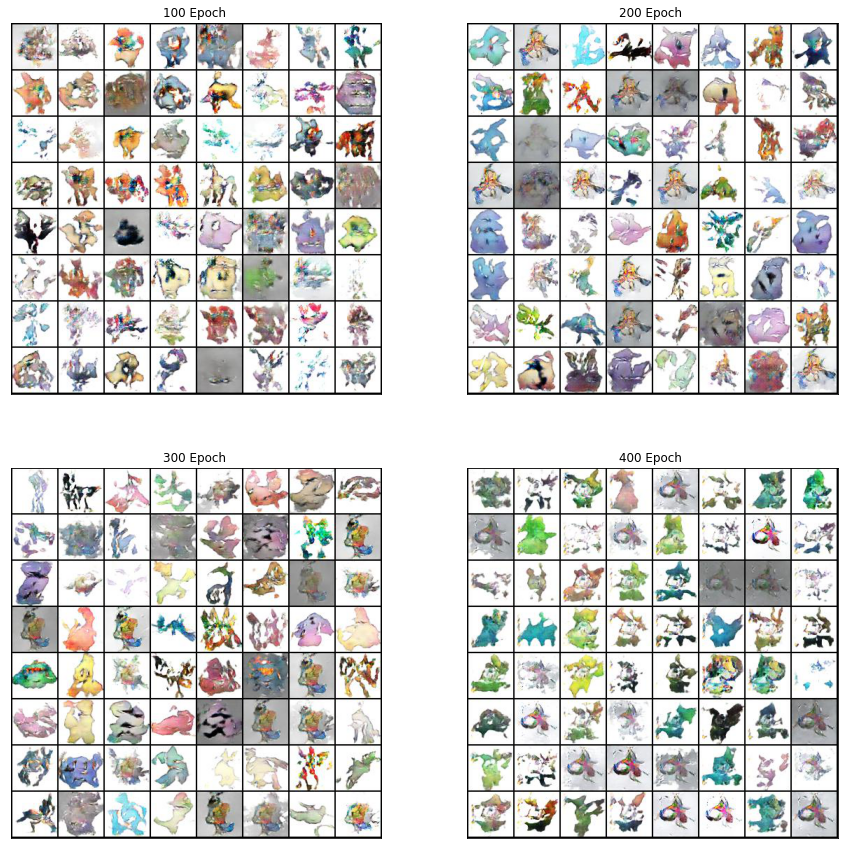

In [31]:
import matplotlib.pyplot as plt
def ShowResults(index) :
    image = []
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[0]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[1]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[2]))))
    image.append(plt.imread(os.path.join(results_path,"{} Epoch .jpg".format(index[3]))))
    f, ax = plt.subplots(2,2,figsize=(15,15))
    ax[0,0].imshow(image[0])
    ax[0,1].imshow(image[1])
    ax[1,0].imshow(image[2])
    ax[1,1].imshow(image[3])
    ax[0,0].set_title("{} Epoch ".format(index[0]))
    ax[0,1].set_title("{} Epoch ".format(index[1]))
    ax[1,0].set_title("{} Epoch ".format(index[2]))
    ax[1,1].set_title("{} Epoch ".format(index[3]))
    ax[0,0].set_xticks([]); ax[0,0].set_yticks([])
    ax[0,1].set_xticks([]); ax[0,1].set_yticks([])
    ax[1,0].set_xticks([]); ax[1,0].set_yticks([])
    ax[1,1].set_xticks([]); ax[1,1].set_yticks([])
    plt.show()
ShowResults([100,200,300,400])

Lets create a short video of each epoch result

In [ ]:
import cv2
import os

video_path = os.path.join(results_path,'RESULTS.avi')

files = [os.path.join(results_path, f) for f in os.listdir(results_path) if 'Epoch' in f]
files.sort(key=lambda fname: int(fname.split(results_path + '/')[1].split(' ')[0]))
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'MP4V'), 1, (image[0].shape[0],image[0].shape[1]))
[out.write(cv2.imread(file)) for file in files]
out.release()

In [21]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp

Evaluate the Generator  with FID metric

In [22]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
 # calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
def EvaluateFidScore(RealPokemon) :
    vectors = torch.randn(128, latent_size, 1, 1, device=device) # 128 vectors of length latent_Size 
    FakePokemon = generator(vectors) # create 128  fake images
    images1 = RealPokemon.transpose(1,3).detach().numpy()
    images2 = FakePokemon.transpose(1,3).detach().numpy()

    # prepare the inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

    shuffle(images1)
    print('Loaded', images1.shape, images2.shape)
    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    print('Scaled', images1.shape, images2.shape)
    # calculate fid
    fid = calculate_fid(model, images1, images2)
    print('FID: %.3f' % fid)
    return fid

Evaluate The Generator with Inception Score

In [28]:
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))	
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std
  
def EvaluteIS() :
	vectors = torch.randn(128, latent_size, 1, 1, device=device) # 64 vectors of length latent_Size 
	FakePokemon = generator(vectors) # create 128  fake images
	images = FakePokemon.transpose(1,3).detach().numpy()
	print('loaded', images.shape)
	# calculate inception score
	is_avg, is_std = calculate_inception_score(images)
	print('score', is_avg, is_std)
	return is_avg

In [29]:
dataloader = DataLoader(dataset, 128, shuffle=True, num_workers=0, pin_memory=False)
RealPokemon, labels = next(iter(dataloader)) # 128 real pokemon images from the data

In [57]:
calculate_inception_score(RealPokemon.transpose(1,3).detach().numpy())

(2.705937, 0.23052818)

In [30]:
FID = []
IS = []
for k in range (5,300,5) :
  generator.load_state_dict(torch.load(checkpoint_path_generator.format(k), map_location=torch.device('cpu'))) #loading the generator weight from k epoch
  fid = EvaluateFidScore(RealPokemon)
  iss = EvaluteIS()
  IS.append(iss)
  FID.append(fid)

Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 358.623
loaded (128, 64, 64, 3)
96124928/96112376 [==============================] - 1s 0us/step
score 2.0211146 0.18047385
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 331.184
loaded (128, 64, 64, 3)
score 1.9073054 0.14412111
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 337.181
loaded (128, 64, 64, 3)
score 1.7576387 0.23731486
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 318.712
loaded (128, 64, 64, 3)
score 1.6717253 0.13910568
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 304.548
loaded (128, 64, 64, 3)
score 1.7953494 0.17663464
Loaded (128, 64, 64, 3) (128, 64, 64, 3)
Scaled (128, 299, 299, 3) (128, 299, 299, 3)
FID: 318.501
loaded (128, 64, 64, 3)
score 1.8676666 0.14989138
Loaded (128, 64, 64, 3) (128, 64, 6

 Performance Analysis

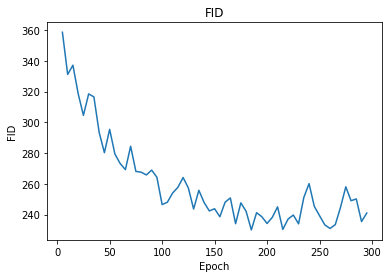

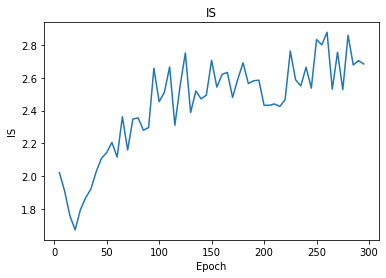

In [36]:
def plot_learning_curve(FID):
    i = range(5,300,5)
    plt.plot(i,FID)
    plt.xlabel('Epoch')
    plt.ylabel('FID')
    plt.title('FID')
    plt.show()

    plt.plot(i,IS)
    plt.xlabel('Epoch')
    plt.ylabel('IS')
    plt.title('IS')
    plt.show()
  
plot_learning_curve(FID)

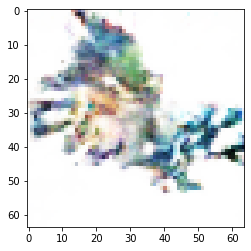

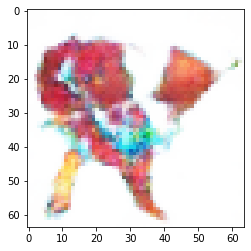

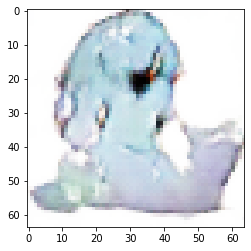

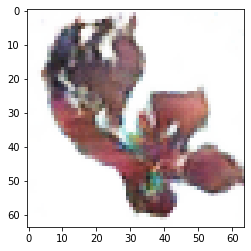

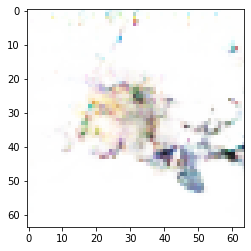

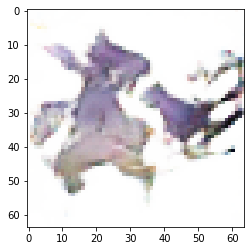

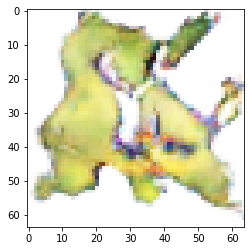

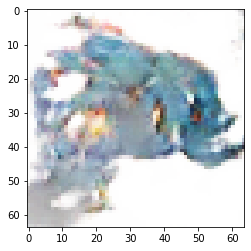

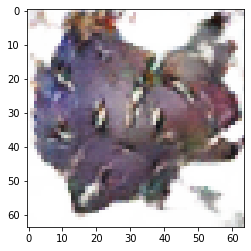

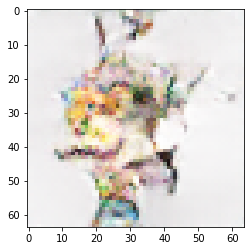

In [54]:
coolImages = generator(torch.randn(10, latent_size, 1, 1, device=device))
for img in coolImages:
  plt.imshow(denorm(img.permute(1, 2, 0)).detach().numpy())
  plt.show()